Loading T2 to get grid ...
Loaded T2_2000-03.nc (cached)
Computing microphysics totals ...
Loaded RAINNC_2000-03.nc (cached)
Loaded SNOWNC_2000-03.nc (cached)
Loaded HAILNC_2000-03.nc (cached)
Loaded GRAUPELNC_2000-03.nc (cached)
Loaded I_RAINNC_2000-03.nc (cached)
Computing linear PPM totals ...
Loaded T2_2000-03.nc (cached)
Loaded I_RAINNC_2000-03.nc (cached)
Loaded RAINNC_2000-03.nc (cached)
Computing sigmoidal PPM totals ...
Loaded T2_2000-03.nc (cached)
Loaded I_RAINNC_2000-03.nc (cached)
Loaded RAINNC_2000-03.nc (cached)


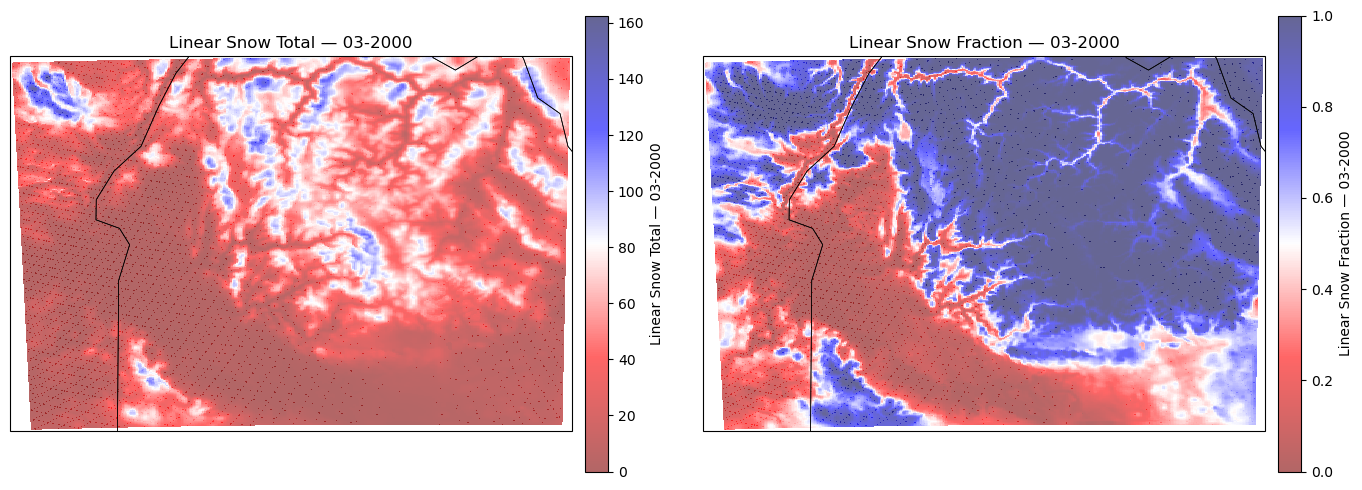

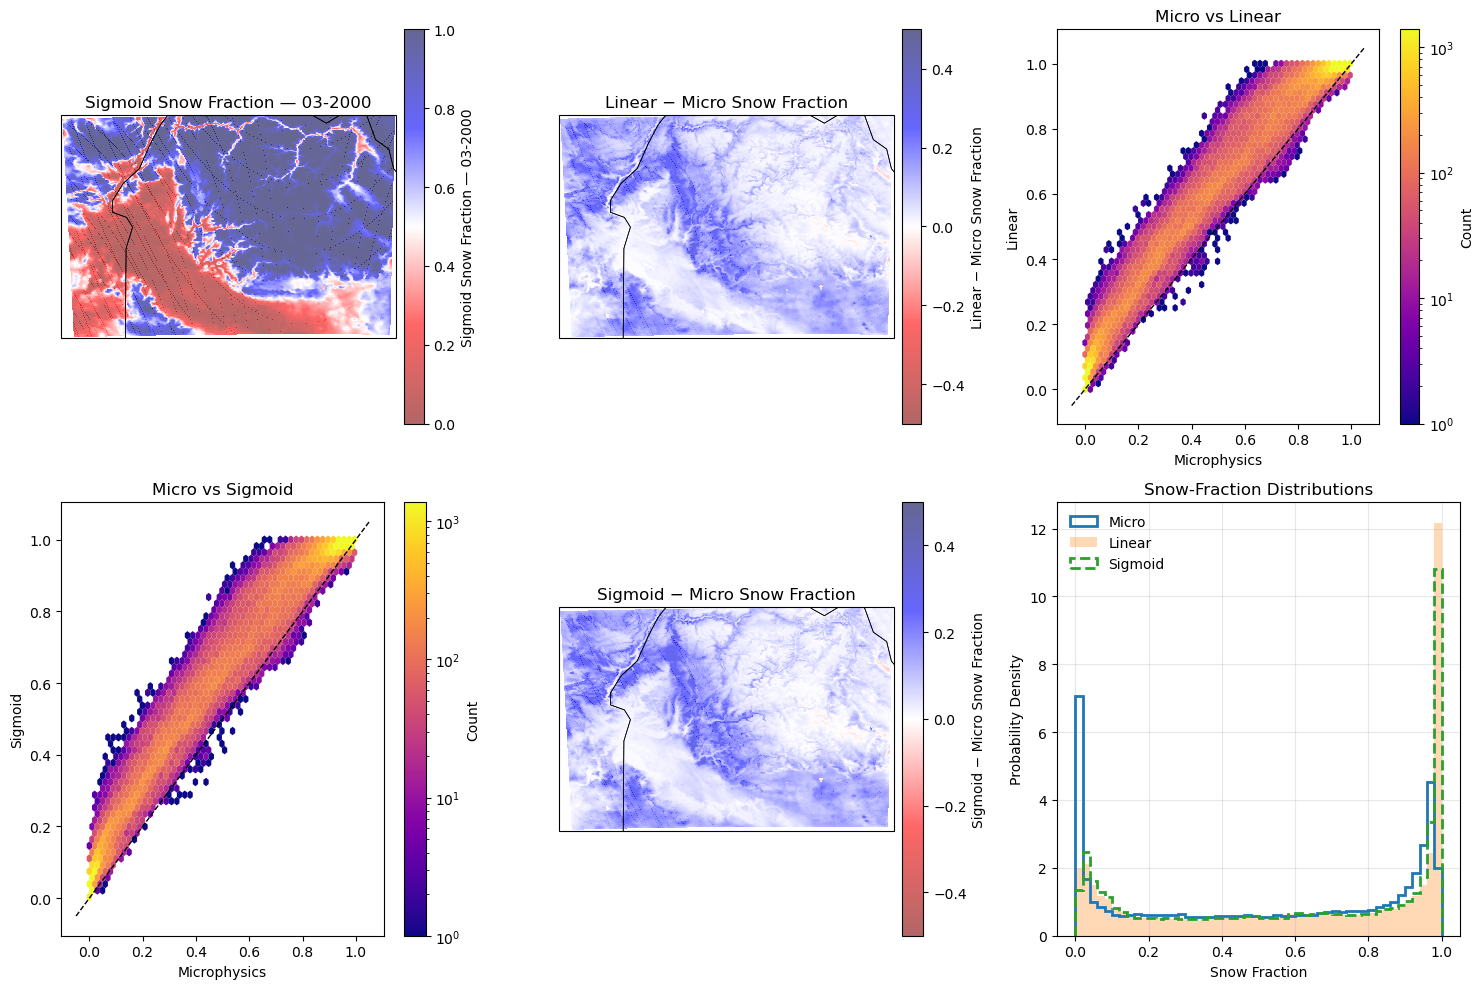

In [18]:
# -----------------------------------------------------------------------------
# compare_03_2000_driver.py  —  Driver script / notebook cell content
# -----------------------------------------------------------------------------
# Goal:
#   * Load March 2000 WRF fields
#   * Compute snow fraction via microphysics, linear, and sigmoidal schemes
#   * Plot side-by-side maps and multi-panel diagnostics (diffs, hexbins, hists)
#
# Assumes plot_utils.py is in PYTHONPATH and contains the functions imported below.
# -----------------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from importlib import reload

import plot_utils; reload(plot_utils)
from plot_utils import (
    load_wrf_var,
    compute_microphysics_snow_frac,
    compute_linear_snow_frac,
    compute_sigmoidal_snow_frac,
    snow_frac_sigmoid,
    plot_cartopy, # standalone map (optional)
    cartomap, # axis-aware map
)

# ==========================
# CONFIGURATION BLOCK
# ==========================
D02_DIR = "/bsushare/leaf-shared/subset-output-wrf/vol04/wrf_out/wy_2000/d02/"
YEAR, MONTH = "2000", "03"
EPSILON = 1e-6

# Microphysics
MIN_PRECIP_MONTH = 1.0 # mm, mask threshold for monthly sums

# Linear PPM settings
MIN_PRECIP_HR = 0.1 # mm/hr mask threshold for hourly precip
T_SNOW_LINEAR = 0.0 # °C (all snow below)
T_RAIN_LINEAR = 5.0 # °C (all rain above)

# Sigmoidal PPM settings
T_SNOW_SIG = 0.0 # °C where F ≈ F_SNOW_TARGET
T_RAIN_SIG =  5.0 # °C where F ≈ F_RAIN_TARGET
F_SNOW_TARGET = 0.95 # fraction at cold anchor
F_RAIN_TARGET = 0.05 # fraction at warm anchor

# Plot styling
HEX_GRIDSIZE = 50
HEX_TRIM_PCT = 99.0
CMAP_MAP = "seismic_r"
CMAP_DIFF = "seismic_r"
CMAP_HEX = "plasma"

# Min max for color displays
FRAC_MIN,  FRAC_MAX  = 0.0, 1.0 # for any fraction map
DIFF_MIN,  DIFF_MAX  = -0.5, 0.5 # for difference maps (e.g., Lin–Micro)
SNOW_MIN,  SNOW_MAX  = 0.0, None # totals; None lets matplotlib pick the max

# ==========================
# LOAD GRID / STATICS
# ==========================
# We only need XLONG/XLAT, pull from T2 file
print("Loading T2 to get grid ...")
t2_ds = load_wrf_var("T2", D02_DIR, YEAR, MONTH)
lons = t2_ds["XLONG"][0].values
lats = t2_ds["XLAT"][0].values

# ==========================
# COMPUTE FIELDS
# ==========================
print("Computing microphysics totals ...")
precip_micro, snow_micro, liquid_micro, frac_micro = compute_microphysics_snow_frac(
    D02_DIR, YEAR, MONTH,
    min_precip=MIN_PRECIP_MONTH,
    epsilon=EPSILON
)

print("Computing linear PPM totals ...")
precip_lin, snow_lin, liquid_lin, frac_lin = compute_linear_snow_frac(
    D02_DIR, YEAR, MONTH,
    min_precip_hr=MIN_PRECIP_HR,
    TSNOW_THRESHOLD=T_SNOW_LINEAR,
    TRAIN_THRESHOLD=T_RAIN_LINEAR,
    epsilon=EPSILON
)

print("Computing sigmoidal PPM totals ...")
precip_sig, snow_sig, liquid_sig, frac_sig = compute_sigmoidal_snow_frac(
    D02_DIR, YEAR, MONTH,
    min_precip_hr=MIN_PRECIP_HR,
    T_snow=T_SNOW_SIG,
    T_rain=T_RAIN_SIG,
    F_snow=F_SNOW_TARGET,
    F_rain=F_RAIN_TARGET,
    epsilon=EPSILON
)

# ==========================
# QUICK SINGLE MAPS (optional)
# ==========================
# plot_cartopy(lons, lats, snow_lin.values,    f"Linear Snow Total — {MONTH}-{YEAR}",   cmap=CMAP_MAP)
# plot_cartopy(lons, lats, snow_sig.values,    f"Sigmoid Snow Total — {MONTH}-{YEAR}",  cmap=CMAP_MAP)
# plot_cartopy(lons, lats, snow_micro.values,  f"Micro Snow Total — {MONTH}-{YEAR}",    cmap=CMAP_MAP)

# ==========================
# SIDE-BY-SIDE LINEAR TRANSITION EXAMPLE (snow total & fraction)
# ==========================
fig1, axs1 = plt.subplots(1, 2, figsize=(14, 5), subplot_kw={'projection': ccrs.PlateCarree()})
cartomap(axs1[0], lons, lats, snow_lin.values,
         f"Linear Snow Total — {MONTH}-{YEAR}",
         cmap="seismic_r", vmin=SNOW_MIN, vmax=SNOW_MAX)
cartomap(axs1[1], lons, lats, frac_lin.values,
         f"Linear Snow Fraction — {MONTH}-{YEAR}",
         cmap=CMAP_DIFF, vmin=FRAC_MIN, vmax=FRAC_MAX)
plt.tight_layout(); plt.show()

# ==========================
# MULTI-PANEL FIGURE (maps, diffs, hexbins, hist)
# Panels:
#   (0,0) Sigmoid Snow Fraction map
#   (0,1) Linear−Micro Fraction difference
#   (0,2) Hexbin Micro vs Linear
#   (1,0) Hexbin Micro vs Sigmoid
#   (1,1) Sigmoid−Micro Fraction difference
#   (1,2) Histogram of fractions
# ==========================

import matplotlib.gridspec as gridspec

fm = np.ma.masked_invalid(frac_micro.values)
fl = np.ma.masked_invalid(frac_lin.values)
fs = np.ma.masked_invalid(frac_sig.values)

diff_lin = fl - fm
diff_sig = fs - fm

fig2 = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 3, figure=fig2, height_ratios=[1, 1.1])

# (0,0) Sigmoid fraction map
ax00 = fig2.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
cartomap(ax00, lons, lats, fs, f"Sigmoid Snow Fraction — {MONTH}-{YEAR}", cmap=CMAP_DIFF, vmin=FRAC_MIN, vmax=FRAC_MAX)

# (0,1) Linear - Micro diff map
ax01 = fig2.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
cartomap(ax01, lons, lats, diff_lin, "Linear − Micro Snow Fraction", cmap=CMAP_DIFF, vmin=DIFF_MIN, vmax=DIFF_MAX)

# Helper: hexbin on given axis
from matplotlib.colors import LogNorm as _LogNorm

def hexbin_on_ax(ax, x, y, gridsize=50, cmap="plasma", log_counts=True,
                 mincnt=1, trim_zeros_ones=True, trim_pct=99.0,
                 xlabel="", ylabel="", title=""):
    xx = np.asarray(x); yy = np.asarray(y)
    good = np.isfinite(xx) & np.isfinite(yy)
    xx, yy = xx[good], yy[good]
    if trim_zeros_ones:
        edge = np.isclose(xx, 0) | np.isclose(xx, 1) | np.isclose(yy, 0) | np.isclose(yy, 1)
        xx, yy = xx[~edge], yy[~edge]
    if log_counts:
        hb = ax.hexbin(xx, yy, gridsize=gridsize, cmap=cmap, bins='log', mincnt=mincnt, edgecolors='none')
    else:
        norm = _LogNorm(vmin=max(mincnt, 1)) if log_counts else None
        hb = ax.hexbin(xx, yy, gridsize=gridsize, cmap=cmap, edgecolors='none', norm=norm)
    if trim_pct is not None:
        arr = hb.get_array(); arr = arr.compressed() if np.ma.isMaskedArray(arr) else arr
        hb.set_clim(vmax=np.percentile(arr, trim_pct))
    ax.set_xlabel(xlabel); ax.set_ylabel(ylabel); ax.set_title(title)
    cb = fig2.colorbar(hb, ax=ax); cb.set_label("Count")
    # 1:1 line
    mn = min(ax.get_xlim()[0], ax.get_ylim()[0]); mx = max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.plot([mn, mx], [mn, mx], 'k--', lw=1)
    return hb

# (0,2) Hexbin Micro vs Linear
ax02 = fig2.add_subplot(gs[0, 2])
hexbin_on_ax(ax02, fm.compressed(), fl.compressed(),
             gridsize=HEX_GRIDSIZE, cmap=CMAP_HEX, log_counts=True,
             trim_pct=HEX_TRIM_PCT,
             xlabel="Microphysics", ylabel="Linear",
             title="Micro vs Linear")

# (1,0) Hexbin Micro vs Sigmoid
ax10 = fig2.add_subplot(gs[1, 0])
hexbin_on_ax(ax10, fm.compressed(), fs.compressed(),
             gridsize=HEX_GRIDSIZE, cmap=CMAP_HEX, log_counts=True,
             trim_pct=HEX_TRIM_PCT,
             xlabel="Microphysics", ylabel="Sigmoid",
             title="Micro vs Sigmoid")

# (1,1) Sigmoid - Micro diff map
ax11 = fig2.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
cartomap(ax11, lons, lats, diff_sig, "Sigmoid − Micro Snow Fraction", cmap=CMAP_DIFF, vmin=DIFF_MIN, vmax=DIFF_MAX)

# (1,2) Histogram of fractions
ax12 = fig2.add_subplot(gs[1, 2])
bins = np.linspace(0, 1, 51)
ax12.hist(fm.compressed(), bins=bins, density=True, histtype="step", linewidth=2, label="Micro")
ax12.hist(fl.compressed(), bins=bins, density=True, histtype="stepfilled", alpha=0.3, label="Linear")
ax12.hist(fs.compressed(), bins=bins, density=True, histtype="step", linestyle="--", linewidth=2, label="Sigmoid")
ax12.set_xlabel("Snow Fraction"); ax12.set_ylabel("Probability Density")
ax12.set_title("Snow‑Fraction Distributions")
ax12.legend(frameon=False)
ax12.grid(alpha=0.3)

plt.tight_layout()
plt.show()
